<a href="https://colab.research.google.com/github/gnurt2041/Facial-Emotion/blob/main/facial_emotions_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
from google.colab import drive
drive.mount('/content/drive')
# Insert the directory

FOLDERNAME = 'Facial_Emotion_Recognition'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 17 07:14:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip  /content/drive/MyDrive/Facial_Emotion_Recognition/archive.zip -d /content/drive/MyDrive/Facial_Emotion_Recognition/

In [80]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [81]:
TRAIN_DIR = '/content/drive/MyDrive/Facial_Emotion_Recognition/train/train/'
TEST_DIR = '/content/drive/MyDrive/Facial_Emotion_Recognition/test/test/'

In [122]:
def load_dataset(directory,mode = None):
    image_paths = []
    labels = []
    if mode == 'train':
        for label in os.listdir(directory):
            for filename in os.listdir(directory+label):
                
                image_path = os.path.join(directory, label, filename)
                image_paths.append(image_path)
                labels.append(label)
            print(label, "Completed")
    elif mode == 'test':
        for label in os.listdir(directory):
            for filename in os.listdir(directory+label):
                mode_test = filename.split('_')
                if mode_test[0] == 'PublicTest':
                    image_path = os.path.join(directory, label, filename)
                    image_paths.append(image_path)
                    labels.append(label)
                
            print(label, "Completed")
    return image_paths, labels

In [83]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR,mode='train')
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
num_train = len(train.index)
print('%d samples'%(num_train))
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed
28709 samples


,image,label
0,/content/drive/MyDrive/Facial_Emotion_Recognit...,neutral
1,/content/drive/MyDrive/Facial_Emotion_Recognit...,surprise
2,/content/drive/MyDrive/Facial_Emotion_Recognit...,sad
3,/content/drive/MyDrive/Facial_Emotion_Recognit...,angry
4,/content/drive/MyDrive/Facial_Emotion_Recognit...,neutral


In [84]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR,mode='test')
num_test = len(test.index)
print('%d samples'%(num_test))
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed
3589 samples


,image,label
0,/content/drive/MyDrive/Facial_Emotion_Recognit...,angry
1,/content/drive/MyDrive/Facial_Emotion_Recognit...,angry
2,/content/drive/MyDrive/Facial_Emotion_Recognit...,angry
3,/content/drive/MyDrive/Facial_Emotion_Recognit...,angry
4,/content/drive/MyDrive/Facial_Emotion_Recognit...,angry


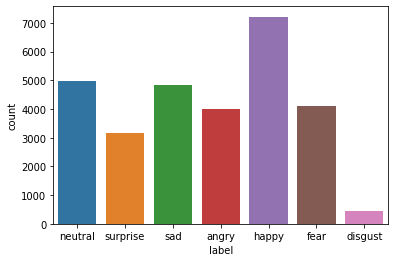

In [85]:
sns.countplot(train['label'])

Random image index: 13758


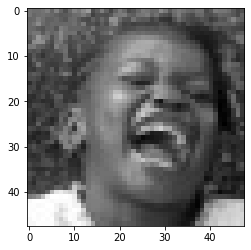

In [107]:
from PIL import Image
rand_index = np.random.choice(num_train,1)[0]
print('Random image index: %d'%(rand_index))
img = Image.open(train['image'][rand_index])
plt.imshow(img, cmap='gray');

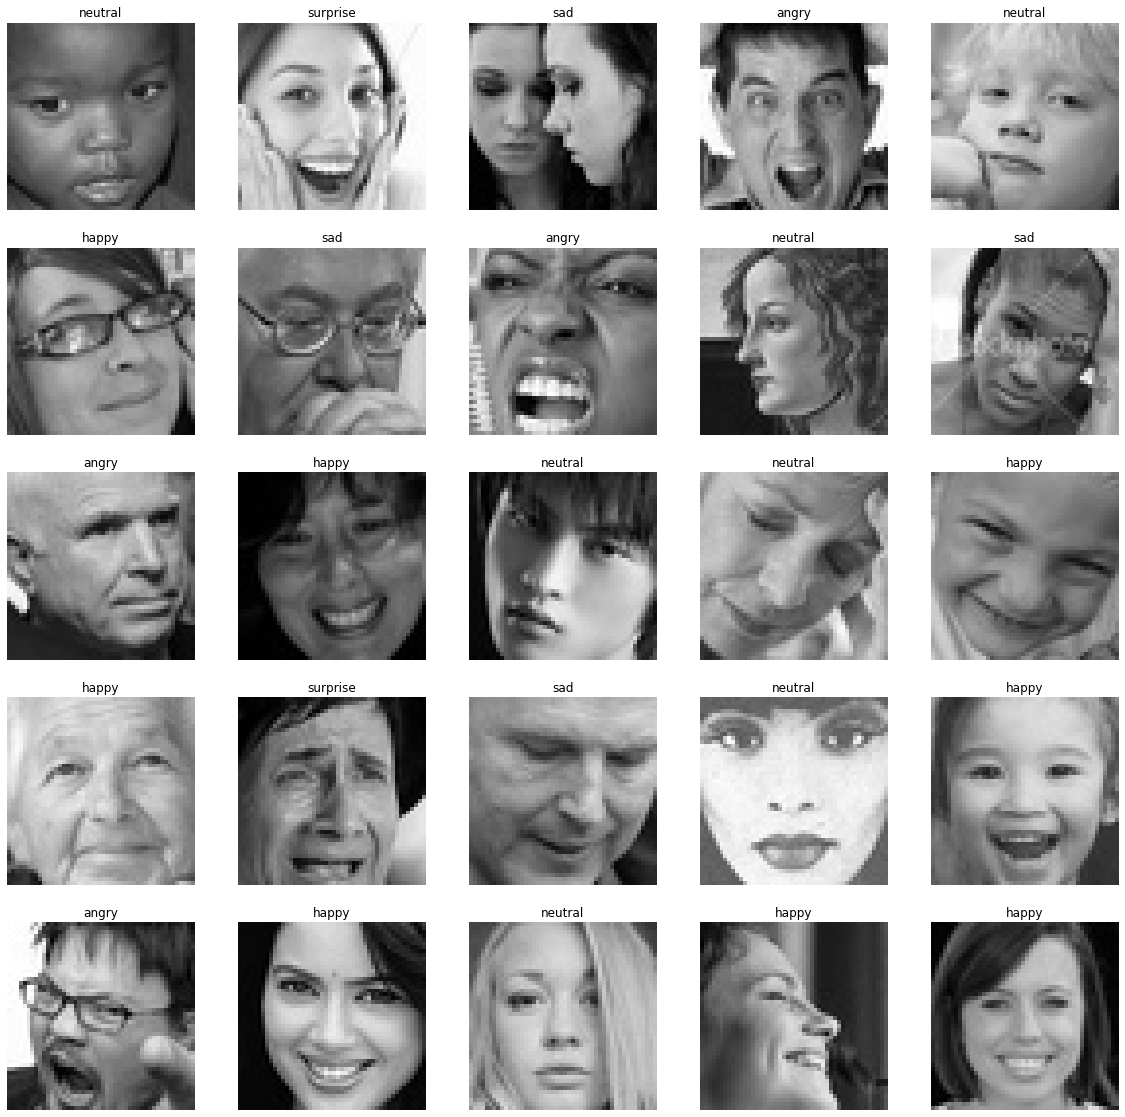

In [108]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [109]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [110]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [111]:
test_features = extract_features(test['image'])

  0%|          | 0/3589 [00:00<?, ?it/s]

In [112]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [113]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [114]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [115]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [116]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [117]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 256)       0

In [ ]:
!pip install livelossplot

In [120]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

In [121]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 25s 54ms/step - loss: 1.8228 - accuracy: 0.2487 - val_loss: 1.8107 - val_accuracy: 0.2494
Epoch 2/100
225/225 [==============================] - 11s 50ms/step - loss: 1.7966 - accuracy: 0.2543 - val_loss: 1.7454 - val_accuracy: 0.2817
Epoch 3/100
225/225 [==============================] - 11s 49ms/step - loss: 1.7155 - accuracy: 0.2976 - val_loss: 1.6143 - val_accuracy: 0.3586
Epoch 4/100
225/225 [==============================] - 11s 49ms/step - loss: 1.5970 - accuracy: 0.3695 - val_loss: 1.4526 - val_accuracy: 0.4294
Epoch 5/100
225/225 [==============================] - 11s 49ms/step - loss: 1.4928 - accuracy: 0.4183 - val_loss: 1.3861 - val_accuracy: 0.4419
Epoch 6/100
225/225 [==============================] - 12s 52ms/step - loss: 1.4277 - accuracy: 0.4477 - val_loss: 1.3459 - val_accuracy: 0.4748
Epoch 7/100
225/225 [==============================] - 12s 51ms/step - loss: 1.3904 - accuracy: 0.4661 - val_loss: 1.2766 - val_ac

In [138]:
model_json = model.to_json()
model.save_weights('model_weights.h5')
with open("model.json", "w") as json_file:
    json_file.write(model_json)

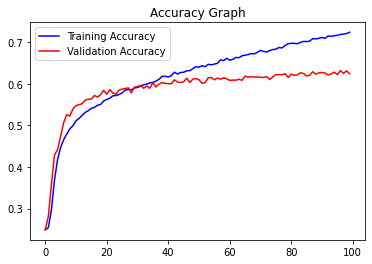

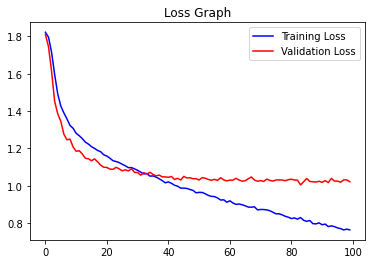

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Original Output: neutral
1/1 [==============================] - 0s 24ms/step
Predicted Output: neutral


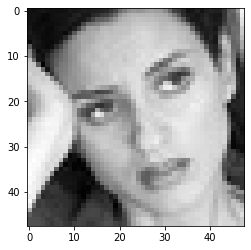

In [183]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

[2514  756 3490]
1/1 [==============================] - 0s 16ms/step


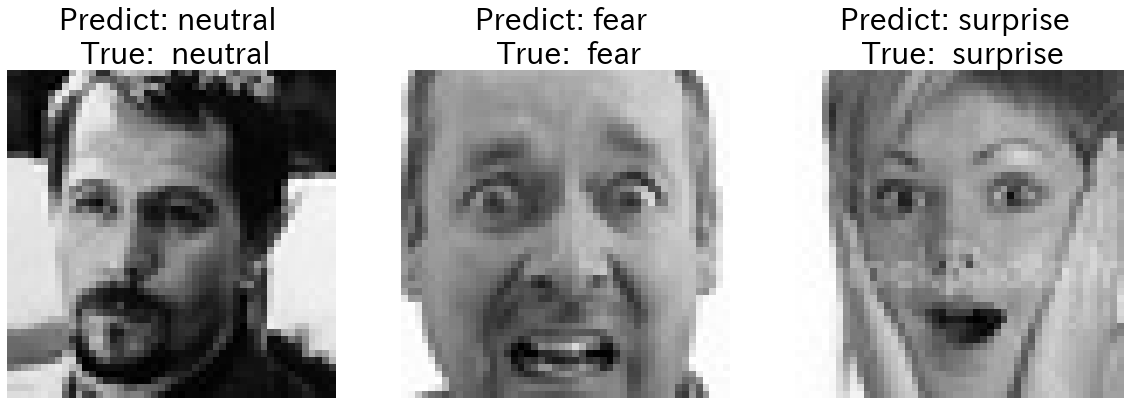

In [234]:
rand_idxs = np.random.choice(len(test),3)
print(rand_idxs)
plt.figure(figsize=(20,20))
for i, img_idx in enumerate(rand_idxs):
    true_label = test['label'][img_idx]
    pred = model.predict(x_test[img_idx].reshape(1, 48, 48, 1))
    prediction_label = le.inverse_transform([pred.argmax()])[0]
    plt.subplot(1,3, i+1)
    plt.title(f'Predict: {prediction_label} \n True:  {true_label}',fontsize=30)
    plt.axis('off')
    plt.imshow(x_test[img_idx].reshape(48, 48), cmap='gray');

In [ ]:
# 日本語で
!pip install japanize-matplotlib

In [210]:
import japanize_matplotlib
uk_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']
jap_labels = ['怒り','嫌悪','恐怖','幸福','中立','悲しみ','驚き']

In [196]:
def maping(uk_labels, jap_labels,label):
  idx = uk_labels.index(label)
  return jap_labels[idx]

[2514  756 3490]
1/1 [==============================] - 0s 38ms/step


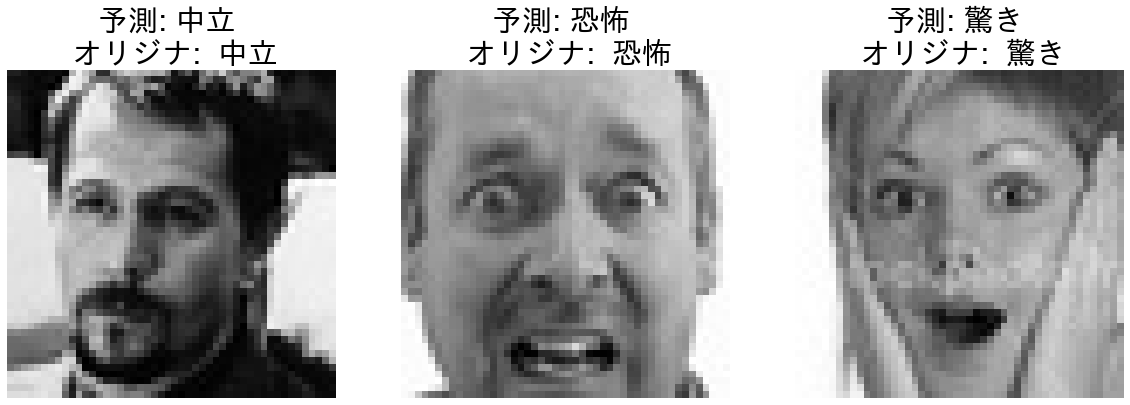

In [233]:
rand_idxs = np.random.choice(len(test),3)
print(rand_idxs)
plt.figure(figsize=(20,20))
for i, img_idx in enumerate(rand_idxs):
    true_label = test['label'][img_idx]
    jap_label = maping(uk_labels, jap_labels, true_label)
    pred = model.predict(x_test[img_idx].reshape(1, 48, 48, 1))
    jap_predict = jap_labels[[pred.argmax()][0]]
    plt.subplot(1,3, i+1)
    plt.title(f'予測: {jap_predict} \n オリジナ:  {jap_label}',fontsize=30)
    plt.axis('off')
    plt.imshow(x_test[img_idx].reshape(48, 48), cmap='gray');